<a href="https://colab.research.google.com/github/maciejskorski/ml_examples/blob/master/SketchEngineScrapper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary

This notebook shows how to use [Selenium](https://www.selenium.dev/) to **automate login and data scrapping** in a non-trivial way.

The page chosen for this demo requires precise element location (XPATH to overcome redundancy in names) and waiting for elements availability and clickability. The code required careful inspection of html element names (achieved with Chrome Developer Tools).

Crendetials for a demo account at the platform [SketchEngine](https://www.sketchengine.eu/) are stored as Colab secrets.

🏆 This notebook was used to reconstruct "Great Recession News Corpus".

In [1]:
try:
  from selenium import webdriver
except:
  !apt-get update -qq
  !pip install selenium --quiet --progress-bar off
  !apt install chromium-chromedriver --quiet --progress-bar off
  !cp /usr/lib/chromium-browser/chromedriver /usr/bin

from selenium import webdriver

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless') # this is must
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument("--start-maximized")

driver = webdriver.Chrome(options=chrome_options)

In [2]:
from google.colab import userdata

USER_NAME = userdata.get('sketchengine_user')
USER_PSSWD = userdata.get('sketchengine_psswd')

PROJECT_ID = 'Great Recession News Corpus' # search for a project
FILTER_VAL = 'nytimes' # filter results in Text Analysis
MAX_N_PAGINATED = 500 # paginated pages too look at

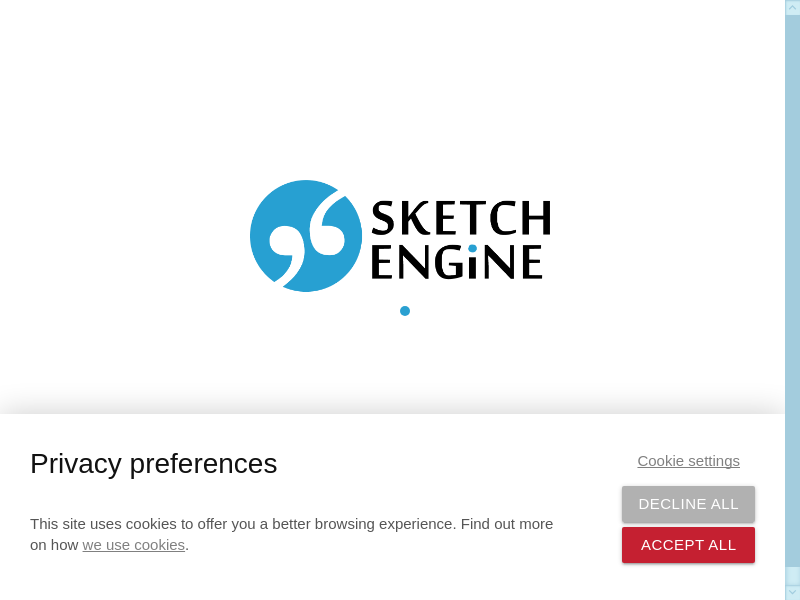

In [3]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import os
import time

url = 'https://auth.sketchengine.eu/#login'
driver.get(url)

# NOTE: use xpath to search precisely, as <email> and <password> names are redundant due to nested elements
# NOTE: wait until elements are clickable!

def get_element_xpath(xpath,wait_condition=EC.element_to_be_clickable):
  return WebDriverWait(driver,10).until(wait_condition((By.XPATH,xpath)))

user_input = get_element_xpath("//input[@name='email']")
user_input.send_keys(USER_NAME)

psswd_input =  get_element_xpath("//input[@name='password']")
psswd_input.send_keys(USER_PSSWD)

try:
  login_bttn = get_element_xpath("//button[text()='Log in']")
  login_bttn.click()
except:
  print("Login Failed!")
finally:
  time.sleep(1)
  with open("screen.png","wb") as f:
    f.write(driver.get_screenshot_as_png())
  from IPython.display import Image, display
  display(Image("screen.png"))

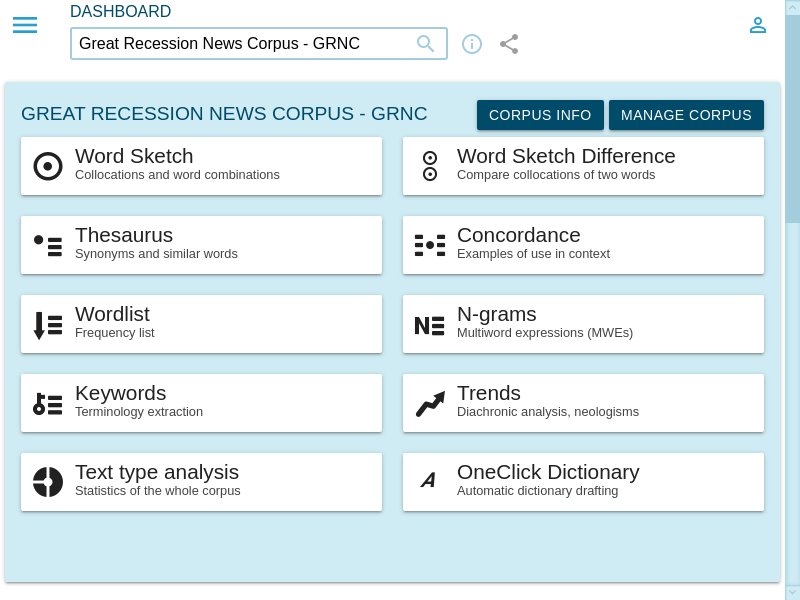

In [4]:
from selenium.webdriver.common.keys import Keys

privacy_bttn = get_element_xpath("//a[@id='SkE_CC_bar_btn_accept_all']") # click privacy to avoid interference with other elements
privacy_bttn.click()

query_input = get_element_xpath("//input[@placeholder='type to search']",)
query_input.send_keys(PROJECT_ID,Keys.ENTER)

time.sleep(3)
with open("screen.png","wb") as f:
  f.write(driver.get_screenshot_as_png())
from IPython.display import Image, display
display(Image("screen.png"))

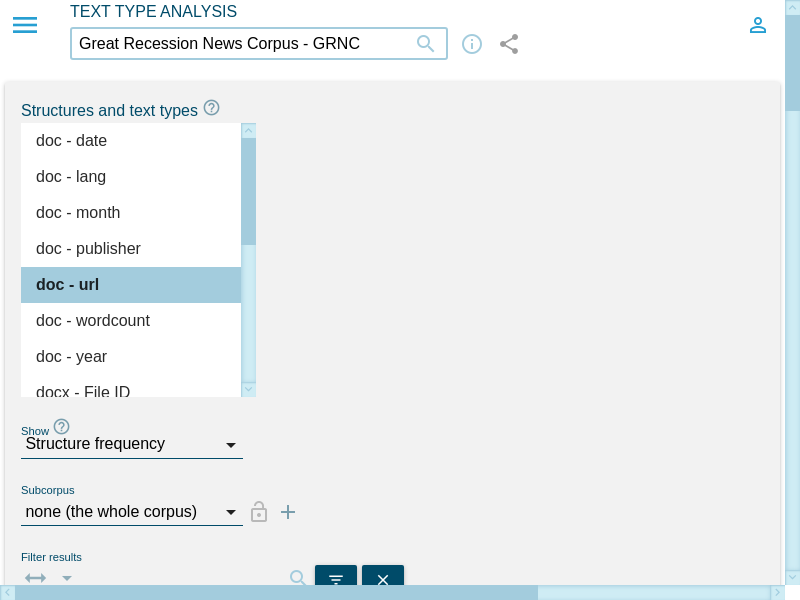

In [5]:
text_analytics = get_element_xpath("//a[@id='dashboard_btntta']")
text_analytics.click()

time.sleep(2) # NOTE: some elements get rebuilt / detatched from DOM

select_item = get_element_xpath("//li[@data-value='doc.url']")
select_item.click()

with open("screen.png","wb") as f:
  f.write(driver.get_screenshot_as_png())
from IPython.display import Image, display
display(Image("screen.png"))

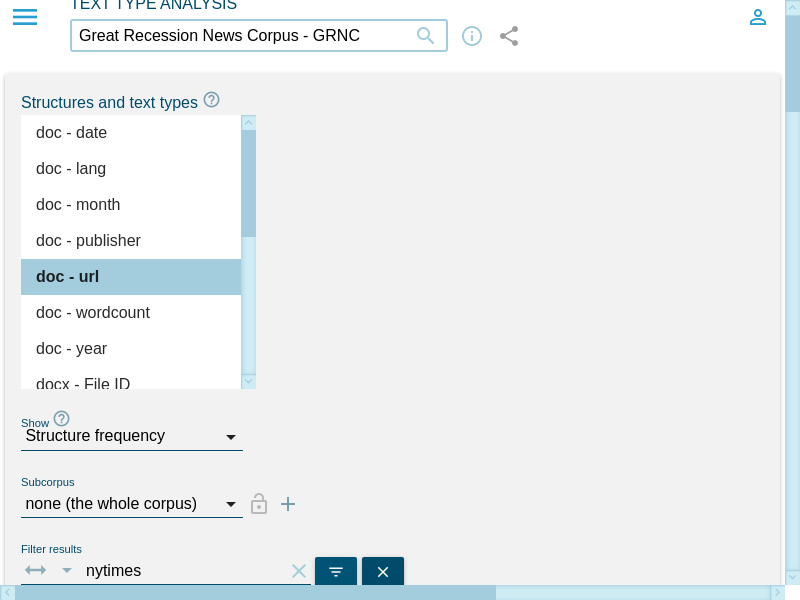

In [6]:
filter = get_element_xpath("//filter-input[@name='filter']")
filter = filter.find_element(By.XPATH,".//input[@type='text']")
filter.send_keys(FILTER_VAL+Keys.ENTER)
filter_bttn = get_element_xpath("//button[@id='btnSubmitFilter']")
filter_bttn.click()

with open("screen.png","wb") as f:
  f.write(driver.get_screenshot_as_png())
from IPython.display import Image, display
display(Image("screen.png"))

In [7]:
import re
from tqdm.auto import tqdm
import pandas as pd

rgx_http = re.compile("http")

all_texts = []

all_data = []

with open("links.txt","wt") as f:
  for i in tqdm(range(MAX_N_PAGINATED)):
    table = get_element_xpath("//table[@class='table material-table']")
    # #rows = table.find_elements(By.TAG_NAME, "td")
    # rows = table.find_elements(By.XPATH, "//td[@class=' _t word']") # use class for links
    # texts = map(lambda td: td.get_attribute("textContent"), rows)
    # texts = filter(rgx_http.search, texts)
    # for line in texts:
    #   f.write(line + '\n')
    df = pd.read_html( table.get_attribute("outerHTML") )[0]
    all_data.append(df)

    fwd_bttn = driver.find_element(By.XPATH,"//i[text()='chevron_right']")
    try:
      fwd_bttn.click()
    except:
      break

  0%|          | 0/500 [00:00<?, ?it/s]

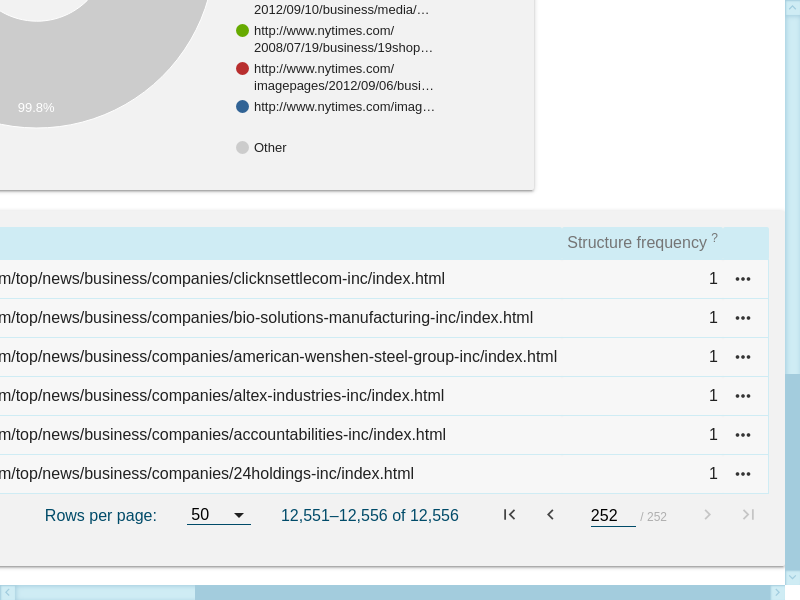

In [8]:
driver.find_element(By.TAG_NAME, 'html').send_keys(Keys.END)

with open("screen.png","wb") as f:
  f.write(driver.get_screenshot_as_png())
from IPython.display import Image, display
display(Image("screen.png"))

In [9]:
df = pd.concat(all_data)
df.to_csv(f"links_{FILTER_VAL}.csv",index=False)
df['Structure frequency ?'].sum()

13069